# PinaColADA Phase 2 Notebook 

The Youniverse dataset consists of 3 main sub-datasets : the channel dataset, the video dataset and the timeseries data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from ThymeBoost import ThymeBoost as tb
import random
from datetime import datetime, timedelta
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import pickle
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### Importing data 

In [108]:
DIR = "./data/"
PATH_CHANNELS_DST = DIR + "df_channels_en.tsv"
PATH_TIME_SERIES_DST = DIR + "df_timeseries_en.tsv"
PATH_COMMENTS_AUTHOR_DST = DIR + "num_comments_authors.tsv"
PATH_COMMENTS_DST = DIR + "num_comments.tsv"
PATH_METADATA_DST = DIR + "yt_metadata_en.jsonl"
PATH_METADATA_HELPER = DIR + "yt_metadata_helper.feather"

In [109]:
channels = pd.read_csv(PATH_CHANNELS_DST, sep = '\t')
channels['join_date']= pd.to_datetime(channels['join_date'])
channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [4]:
timeseries = pd.read_csv(PATH_TIME_SERIES_DST, sep = '\t')
timeseries['datetime'] = pd.to_datetime(timeseries['datetime'])
timeseries = timeseries.round(decimals=3)
timeseries['category'] = timeseries['category'].fillna('Undefined')
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.556,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.667,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,835393.750,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1104577.000,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1284405.600,179828.600,2008.300,258.300,6,0,0


In [5]:
timeseries.to_pickle("./timeseries.pkl")

In [3]:
timeseries = pd.read_pickle("./timeseries.pkl")

### Channels data exploration

In [5]:
channels.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


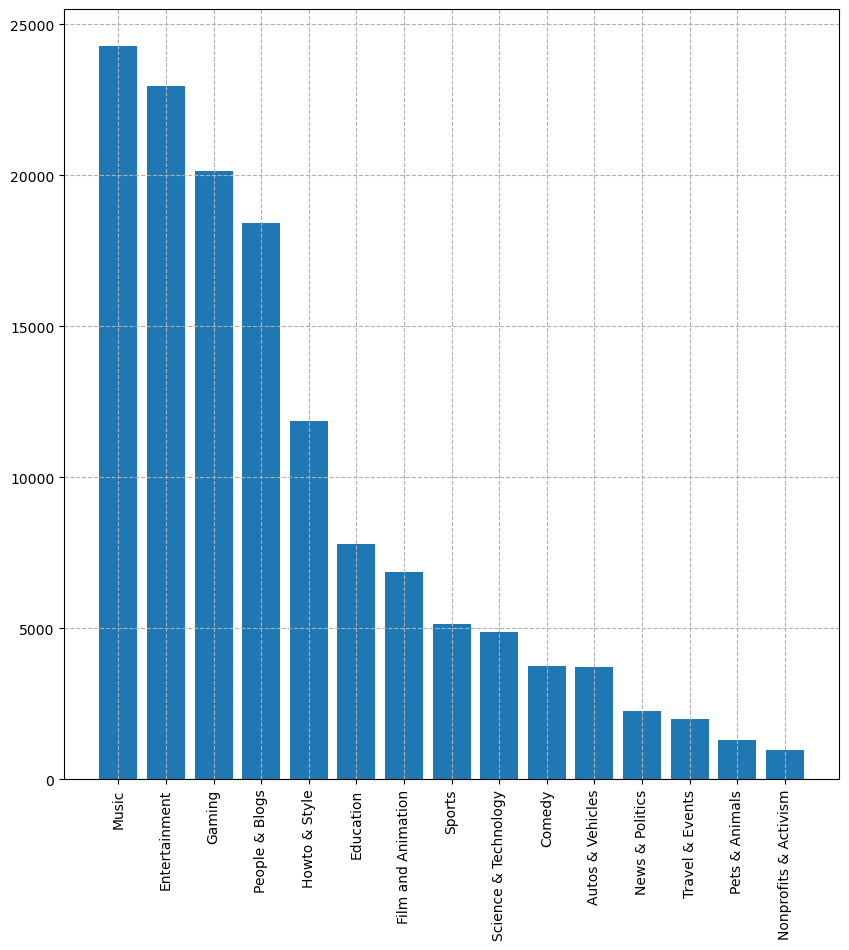

In [6]:
# Group the channels by categories
categories = channels.groupby(['category_cc']).size().to_frame()
categories.rename(columns={0:'count'}, inplace=True)

# Sort and plot the resulting data
categories.sort_values(by='count', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.grid(linestyle='--')
plt.bar(categories.index, categories['count'])
plt.xticks(rotation = 90)
plt.show()

We can see that there is a minority of categories that concentrate a large part of the channels: this can be explained by the fact that these are categories with much broader subjects than others (such as for example Entertainment compared to Pets & Animals) but also by the fact that some can be used by actors fondamentally different than typical Youtube content creators (like Music with artist channels).


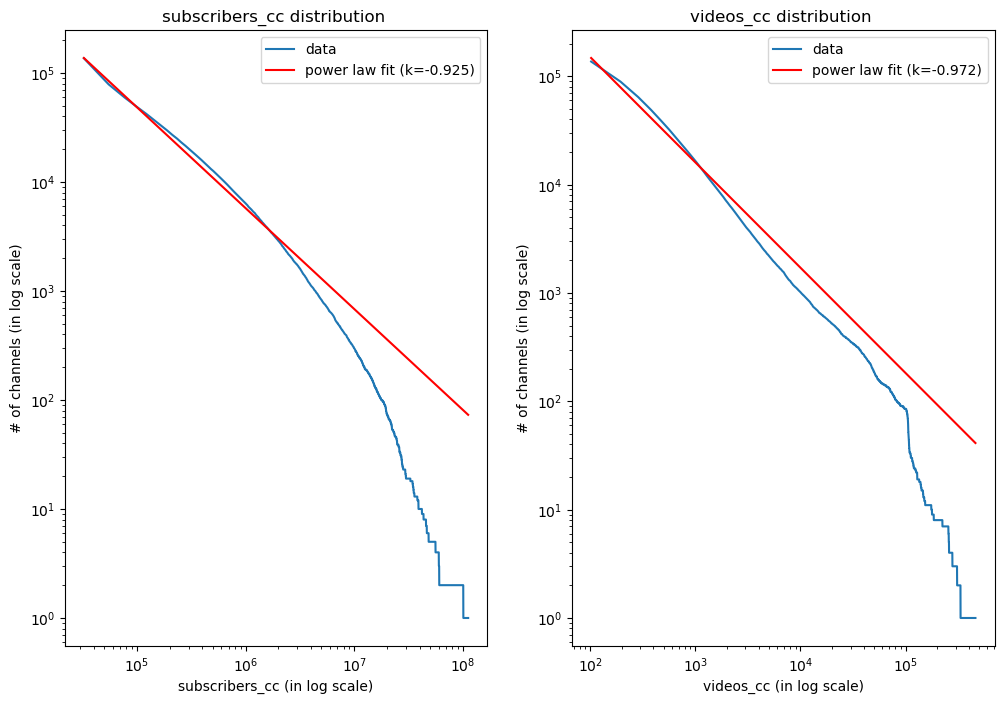

In [7]:
# Power law definition : required for fitting the data
def power_law(x, a, k):
    return a * (x ** k)

# For each category to plot :
power_law_cat = ['subscribers_cc', 'videos_cc']
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for idx, cat in enumerate(power_law_cat):
    
    # Group the data into bins
    array_hist = ax[idx].hist(channels[cat], bins=5000,log=True,cumulative=-1,histtype='step')
    ax[idx].clear()
    
    # Fit the data to find a suitable power law
    popt, pcov = curve_fit(power_law,array_hist[1][1:],  array_hist[0])
    
    # Plot both the data and the fitted function
    ax[idx].loglog(array_hist[1][1:],array_hist[0], label='data')
    ax[idx].loglog(array_hist[1][1:], power_law(array_hist[1][1:], *popt), 'r-', label='power law fit (k=%.3f)' % tuple(popt)[1])
    ax[idx].set_title(f'{cat} distribution ')
    ax[idx].set_ylabel('# of channels (in log scale)')
    ax[idx].set_xlabel(f'{cat} (in log scale)')
    ax[idx].legend()

plt.show()                                                                  

The subscribers count follows a power law : the vast majority of Youtube channels have a low number of subscribers while only a few channel concentrate the major part of subscriptions.
We can also make this statement about the number of published videos per channels

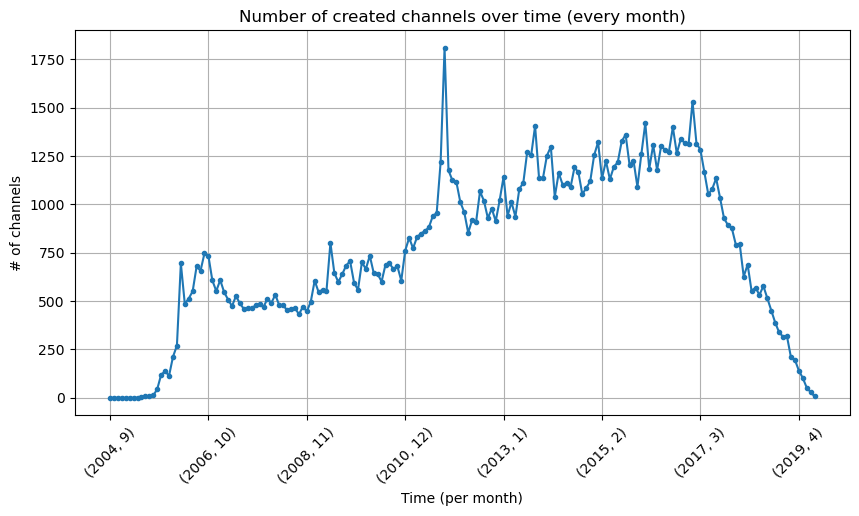

In [8]:
# Count the value of join_date 
creation_dt_df = channels['join_date'].value_counts().to_frame()

# Add missing values (if there was no channel created during a certain month we have to add 0-entry to our dataframe)
idx = pd.date_range(creation_dt_df.index.min(), creation_dt_df.index.max())
creation_dt_df.index = pd.DatetimeIndex(creation_dt_df.index)
creation_dt_df = creation_dt_df.reindex(idx, fill_value=0)

# Group the data by year and month to get an approrpiate scale
creation_dt_df = creation_dt_df.groupby([(creation_dt_df.index.year), (creation_dt_df.index.month)]).sum()

# Plot the final dataset 
creation_dt_df.plot(kind='line',figsize=(10,5), grid='--', legend=False, rot=45, marker=".")
plt.title('Number of created channels over time (every month)')
plt.ylabel('# of channels')
plt.xlabel('Time (per month)')
plt.show()

We can see that there is a considerable attraction for Youtube from its creation in 2005 and in the 2010s followed by a significant drop from 2017 where less and less channels are created.

### Timeseries data exploration

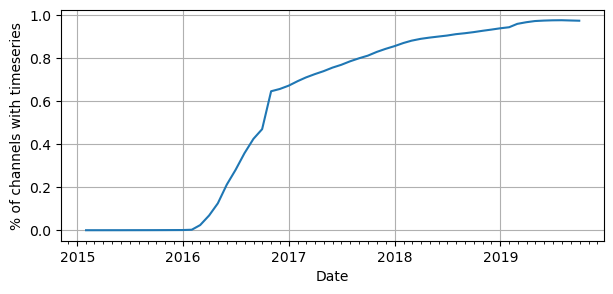

In [9]:
# Group the channel month 
datetimes = timeseries.groupby(pd.Grouper(key="datetime", freq="M")).channel.nunique()
channels_tot = len(timeseries.channel.unique())

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})
# sns.lineplot(data=(datetimes / channels_tot), ax=ax)
ax.plot(datetimes / channels_tot)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel("Date")
ax.set_ylabel("% of channels with timeseries")
ax.grid()

From the graph above, we can see that there is relatively big expansion of the number of channels from 2016 to 2017 and grows slower after. From that we decide to pick only timeseries starting timestamp in March 2017. Also we decide to take channels that have at least 140 timestamps (which correspond to ~3 years)

In [4]:
timeseries_filtered = timeseries[timeseries.datetime >= pd.to_datetime("2017-3-1")]
print("We know have {} datapoints".format(len(timeseries_filtered)))

We know have 15899418 datapoints


### Timestamps uniformization

In [5]:
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("Without uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

Without uniformization, we have 270 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05 23:00:00,5084.151,29511.854,NaN,79230.630,81655.203,80741.172,NaN,NaN,185740.719,3194.245,...,1299.214,10319.792,NaN,16790.245,7451.599,NaN,NaN,21433.500,0.0,66594.318
2017-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,337.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-12 23:00:00,4121.281,27776.422,NaN,75579.474,111415.917,56396.365,NaN,NaN,176101.714,1703.115,...,3388.875,8655.021,NaN,17796.646,7980.000,NaN,NaN,37286.031,0.0,66848.464
2017-03-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,370.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 23:00:00,3331.469,29902.391,NaN,81068.396,70171.418,46221.240,NaN,NaN,185874.396,1472.786,...,2478.203,10301.375,NaN,18620.229,12789.391,NaN,NaN,53305.041,0.0,63590.495


When setting up our data structure, we noticed that there was some small issues in the timeseries datapoints timsestamp : as the data was not crawled at exactly the same time for all channels, there are not the same all across. If we look at the table just above, you can see that there are timestamps that should have been pooled at around the same time that have a 2-hour difference, resulting in additional rows for parts of the dataset. We have timestamps for one day at 23h00 and for the day after at 1h00 or 00h00.

Since the hour of the time isn't relevant in our study, we decided to substract 2-hour from the timestamp : for the timestamp indicating 23h00, this won't change anything but for the timestamp indicating 00h00 or 01h00, this will change the current timestamp day to the previous day, which uniforms timestamps for all channels. 

In [6]:
# Project the timestamp to the correct day
timeseries_filtered.datetime = timeseries_filtered.datetime - timedelta(hours = 2)
# Drop the time to only keep the day
timeseries_filtered.datetime = pd.to_datetime(timeseries_filtered.datetime).dt.date
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("With uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

With uniformization, we have 135 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05,5084.151,29511.854,NaN,79230.630,81655.203,80741.172,NaN,NaN,185740.719,3194.245,...,1299.214,10319.792,337.750,16790.245,7451.599,NaN,NaN,21433.500,0.0,66594.318
2017-03-12,4121.281,27776.422,NaN,75579.474,111415.917,56396.365,NaN,NaN,176101.714,1703.115,...,3388.875,8655.021,370.125,17796.646,7980.000,NaN,NaN,37286.031,0.0,66848.464
2017-03-19,3331.469,29902.391,NaN,81068.396,70171.418,46221.240,NaN,NaN,185874.396,1472.786,...,2478.203,10301.375,195.375,18620.229,12789.391,NaN,NaN,53305.041,0.0,63590.495
2017-03-26,3510.386,33918.421,NaN,96758.761,52380.817,47386.811,NaN,NaN,202878.457,1365.533,...,1860.859,10000.878,187.035,16477.597,8400.880,NaN,NaN,43613.152,0.0,53842.747
2017-04-02,3238.031,36958.507,NaN,72781.822,45465.000,40488.814,NaN,NaN,179269.194,1098.597,...,3452.360,10132.440,205.137,15349.730,9352.778,NaN,NaN,38612.000,0.0,37897.430


There is still some NaN values in the which is normal because not every channel have all timestamps.

### Timestamp distribution

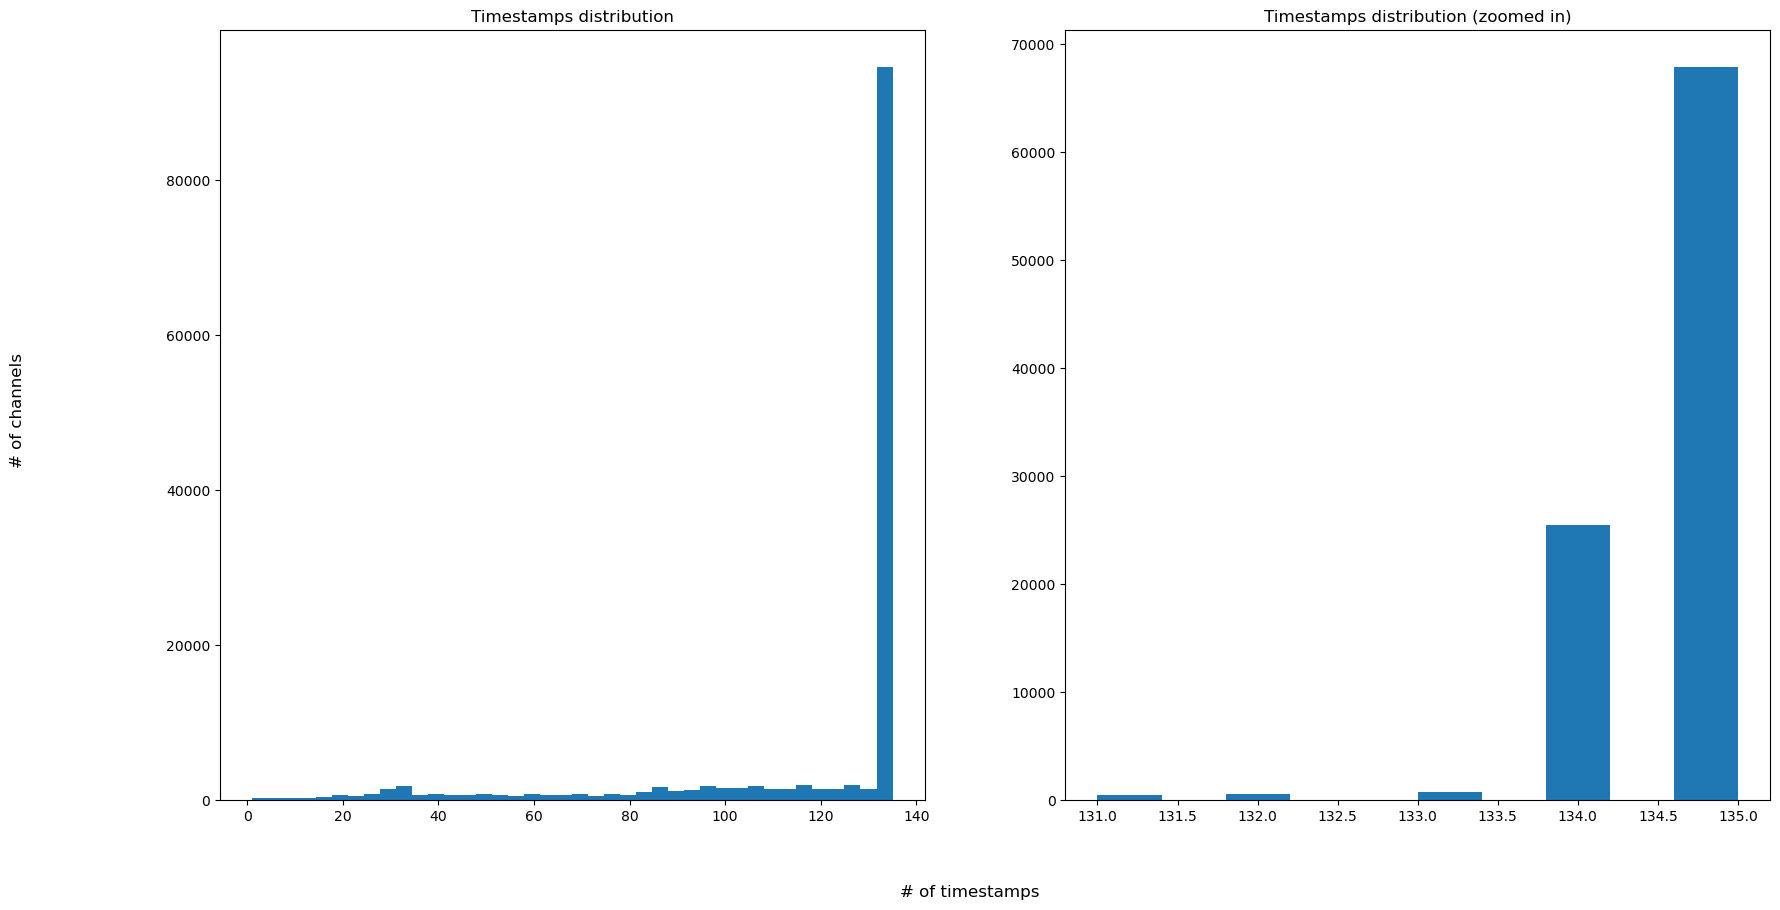

In [7]:
timeseries_sizes = channel_timeseries.count().to_frame()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(timeseries_sizes[0], bins=40)
axes[0].set_title('Timestamps distribution')

axes[1].hist(timeseries_sizes[timeseries_sizes[0]>130], bins=10)
axes[1].set_title('Timestamps distribution (zoomed in)')
fig.supxlabel('# of timestamps')
fig.supylabel('# of channels')
plt.show()

Here you can see that we have the correct number of timestamp that we found in the graph above. Because of this given distribution, we decided to only keep timseries with a small amount of missing timestamps.

In [8]:
channel_timeseries = channel_timeseries.dropna(thresh=len(channel_timeseries) - 1, axis=1)
channel_timeseries.head()

channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,UC--LAVm36WiCmqQbekV17qQ,UC--MxpGXJ3LVD8KvlNzRlcA,UC--SaadDxRXz729rtbQqyBA,...,UCzzfu83LhPMMuhtDVA75rfw,UCzzgEOi0xR9SuflkXmTQv6g,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05,5084.151,29511.854,79230.630,81655.203,80741.172,185740.719,3194.245,345128.635,154075.526,75592.406,...,98601.505,69613.802,1299.214,10319.792,337.750,16790.245,7451.599,21433.500,0.0,66594.318
2017-03-12,4121.281,27776.422,75579.474,111415.917,56396.365,176101.714,1703.115,262139.146,154464.932,78428.974,...,82980.260,78330.370,3388.875,8655.021,370.125,17796.646,7980.000,37286.031,0.0,66848.464
2017-03-19,3331.469,29902.391,81068.396,70171.418,46221.240,185874.396,1472.786,287710.500,162342.188,85739.453,...,63900.214,85821.021,2478.203,10301.375,195.375,18620.229,12789.391,53305.041,0.0,63590.495
2017-03-26,3510.386,33918.421,96758.761,52380.817,47386.811,202878.457,1365.533,219151.809,182142.246,93298.148,...,58096.004,78115.357,1860.859,10000.878,187.035,16477.597,8400.880,43613.152,0.0,53842.747
2017-04-02,3238.031,36958.507,72781.822,45465.000,40488.814,179269.194,1098.597,205884.004,133568.796,73309.571,...,62431.965,68790.221,3452.360,10132.440,205.137,15349.730,9352.778,38612.000,0.0,37897.430


In [9]:
nan_rows = channel_timeseries[channel_timeseries.isna().any(axis=1)]
print(nan_rows.index.values)

[datetime.date(2017, 3, 5) datetime.date(2019, 9, 29)]


In [10]:
long_timeseries = timeseries_filtered[timeseries_filtered['channel'].isin(channel_timeseries.columns)]
long_timeseries = long_timeseries.drop(long_timeseries[long_timeseries['datetime'].isin(nan_rows.index.values)].index)
print(len(long_timeseries))
long_timeseries.head()

12425259


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
168,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-12,1.768565e+07,0.000,8162.125,31.375,835,0,0
169,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-19,1.770991e+07,24259.750,8193.500,31.375,835,0,0
170,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-26,1.778612e+07,76201.330,8229.094,35.594,835,0,0
171,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-04-02,1.786131e+07,75191.410,8267.677,38.583,835,0,0
172,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-04-09,1.793984e+07,78537.104,8299.250,31.573,835,0,0


In [11]:
long_timeseries.to_pickle("./cleantimeseries.pkl")

In [2]:
long_timeseries = pd.read_pickle("./cleantimeseries.pkl")

### Distribution of the mean deltaviews

The plot consist of the number of channels that have the same delta views mean accross the time serie.

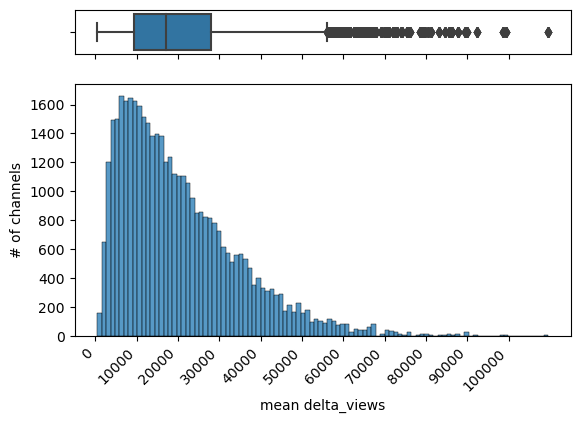

In [128]:
means = long_timeseries.groupby('channel')['delta_views'].mean().round(-1).astype(int)
vc = means.value_counts()[means.value_counts() > 6]
means = means[np.isin(means.values, (vc.index))]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=means, ax=ax_box)
sns.histplot(x=means, ax=ax_hist)
ax_hist.set_xticks(range(0, 110000, 10000))
ax_box.set_xticks(range(0, 110000, 10000))
ax_hist.set_xlabel("mean delta_views")
ax_hist.set_ylabel("# of channels")
f.autofmt_xdate(rotation=45)

Most of the channels have delta_views's mean between 8k - 28k

### Linear Regression of delta views

Loop over all channels to compute the slope and intercept value used for the linear regression. All data are min-max normalize.

In [43]:
slopes = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):
    dv = channel_df['delta_views']
    normalized_df=(dv-dv.min())/(dv.max() - dv.min())
    res = stats.linregress(range(len(channel_df)), normalized_df.values)
    slopes.append((name, res.slope, res.intercept))

100%|██████████| 67936/67936 [00:22<00:00, 3086.59it/s]


Sort the list according to the slopes to see the downfall / rise of channels

In [44]:
slopes_sort = sorted(slopes, key=lambda x: x[1])

Text(0.5, 0.98, 'The most falling / stagnating / rising channels')

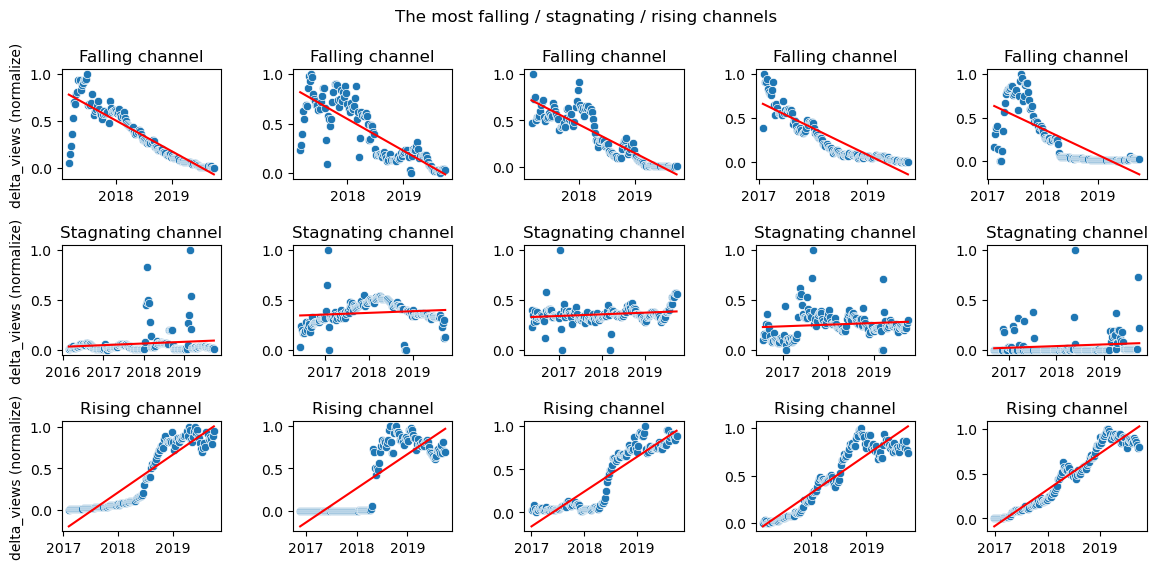

In [45]:
f, axs = plt.subplots(3, 5, figsize=(14, 6), gridspec_kw={"wspace": 0.45, "hspace": 0.6, 
                                      "height_ratios": [1, 1, 1]})

for i, ax in enumerate(axs[0]):
    idx = i
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Falling channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[1]):
    idx = i + int(len(slopes_sort) / 2)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")    
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Stagnating channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[2]):
    idx = -(i + 1)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Rising channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

f.suptitle("The most falling / stagnating / rising channels")

## Dealing with outliers

### Delta_views

As we can see there clearly, there is some channels that, according to our regression, are stagning. But is it truly the case? Look for example the plot in the middle. (2nd row, 1st column). There are some outliers that might influence the regression and hence show that the channel is stagning which is not necessarly the case.

In this way, we wanted to see if outliers indeed influence the slopes or not. In other words, does the slopes with and without outlier changes? Thoses potential changes happend often, in terms of number of channels?. We are doing this to know if outliers influence the rising or the falling and also to answer the question: Does a popular video makes you channel bigger or not?

In [89]:
# Compute the slopes with and without outliers
boosted_model = tb.ThymeBoost()
slope_with_outliers = []
slope_without_outliers = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):

    df_norm = (channel_df['delta_views']-channel_df['delta_views'].min())/(channel_df['delta_views'].max() - channel_df['delta_views'].min())
    
    output = boosted_model.detect_outliers(df_norm,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')
    
    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    slope_with_outliers.append((name, slope, output.yhat.iloc[0]))

    df = df_norm.copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    slope_without_outliers.append((name, slope, output_without_outlier.yhat.iloc[0]))

dict_slope_with_outliers = {}
for el in slope_with_outliers:
    dict_slope_with_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}
    
dict_slope_without_outliers = {}
for el in slope_without_outliers:
    dict_slope_without_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

diff_slopes = {}
for name in dict_slope_with_outliers:
    diff_slopes[name] = abs(dict_slope_with_outliers[name]["slope"] - dict_slope_without_outliers[name]["slope"])

100%|██████████| 93423/93423 [08:22<00:00, 186.01it/s]


In [93]:
def sample_from_dict(d, sample=100):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

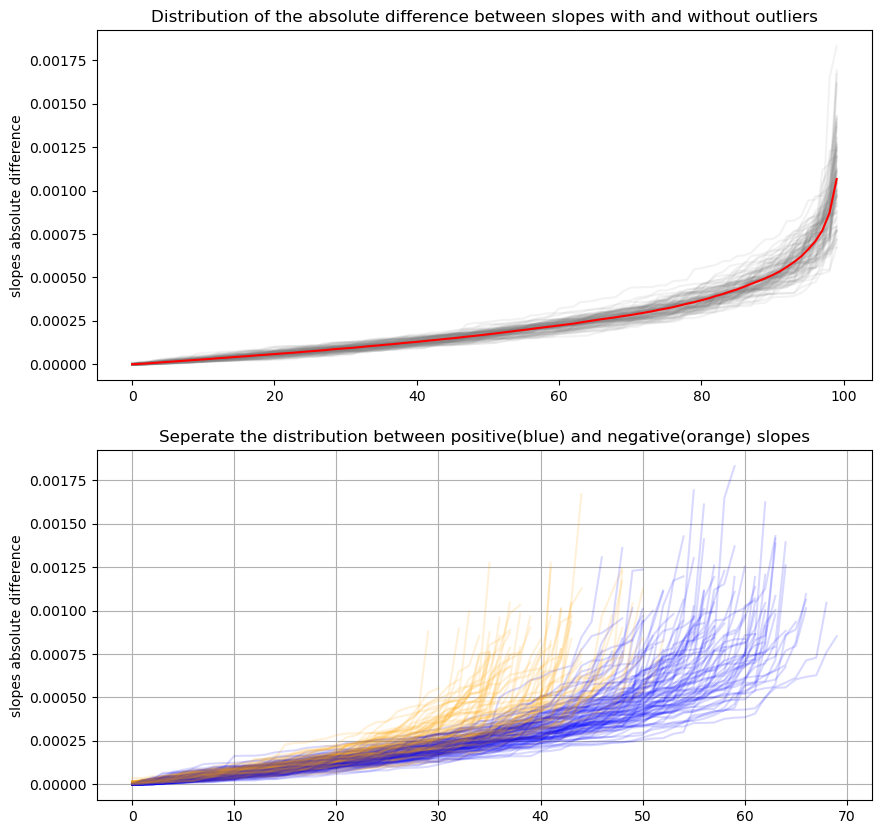

In [166]:
N = 100
mean = 0
mean_pos = np.zeros(N)
mean_neg = np.zeros(N)
fig, ax = plt.subplots(2, figsize=(10, 10))
for i in range(N):
    sample_diff_slopes = sample_from_dict(diff_slopes)
    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    mean += sample_diff_slopes_df.slopes.sort_values().values / N
    ax[0].plot(range(len(sample_diff_slopes_df.index)), sample_diff_slopes_df.slopes.sort_values(), color="grey", alpha=0.1)

    #######################################################################################################################

    sample_dict_slope_with_outliers = {key: dict_slope_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
    sample_dict_slope_without_outliers = {key: dict_slope_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_with_outliers, orient='index', columns=['slopes'])
    sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_without_outliers, orient='index', columns=['slopes'])

    s = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes >= 0]
    u = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(s.index)]
    # mean_pos += np.hstack([u.slopes.sort_values().values, np.ones(N - len(u.slopes.sort_values().values)) * u.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(u)), u.slopes.sort_values(), color="blue", alpha=0.15)

    t = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes < 0]
    v = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(t.index)]
    # mean_neg += np.hstack([v.slopes.sort_values().values, np.ones(N - len(v.slopes.sort_values().values)) * v.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(v)), v.slopes.sort_values(), color="orange", alpha=0.15)

ax[0].plot(range(len(sample_diff_slopes_df.index)), mean, color="red")
ax[0].set_title("Distribution of the absolute difference between views slopes with and without outliers")
ax[0].set_ylabel("views slopes absolute difference")

ax[1].set_title("Seperate the distribution between positive(blue) and negative(orange) views slopes")
ax[1].set_ylabel("views slopes absolute difference")
ax[1].grid()

la distrbution de difference de slope entre avec et sans outlier est differente pour les negatives et positve slope. Pourquoi faire ça? Identifier un pattern qui pour donner des raisons de rise or fall. On peut voir que la distribution est la même et est plutot chaotique
On peut voir qu'il y a plus de chaine avec des slope positive que negative, ce qui impliquerai que le nombre de chaine rising dans youtube augmente. Cependant, nous voyons que la courbe (grpahe 1) de l'absolute difference est exponentiel, meaning most of the channels outliers doesn't really affect the curve of the delta_views time-series.

### Delta_subs

In [177]:
# Compute the slopes with and without outliers
boosted_model = tb.ThymeBoost()
subs_with_outliers = []
subs_without_outliers = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):

    df_norm = (channel_df['delta_subs']-channel_df['delta_subs'].min())/(channel_df['delta_subs'].max() - channel_df['delta_subs'].min())
    if (df_norm.isnull().values.any()):
        continue
    output = boosted_model.detect_outliers(df_norm,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')
    
    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    subs_with_outliers.append((name, slope, output.yhat.iloc[0]))

    df = df_norm.copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    subs_without_outliers.append((name, slope, output_without_outlier.yhat.iloc[0]))

dict_subs_with_outliers = {}
for el in subs_with_outliers:
    dict_subs_with_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

dict_subs_without_outliers = {}
for el in subs_without_outliers:
    dict_subs_without_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

diff_subs = {}
for name in dict_subs_with_outliers:
    diff_subs[name] = abs(dict_subs_with_outliers[name]["slope"] - dict_subs_without_outliers[name]["slope"])

100%|██████████| 93423/93423 [08:12<00:00, 189.70it/s]


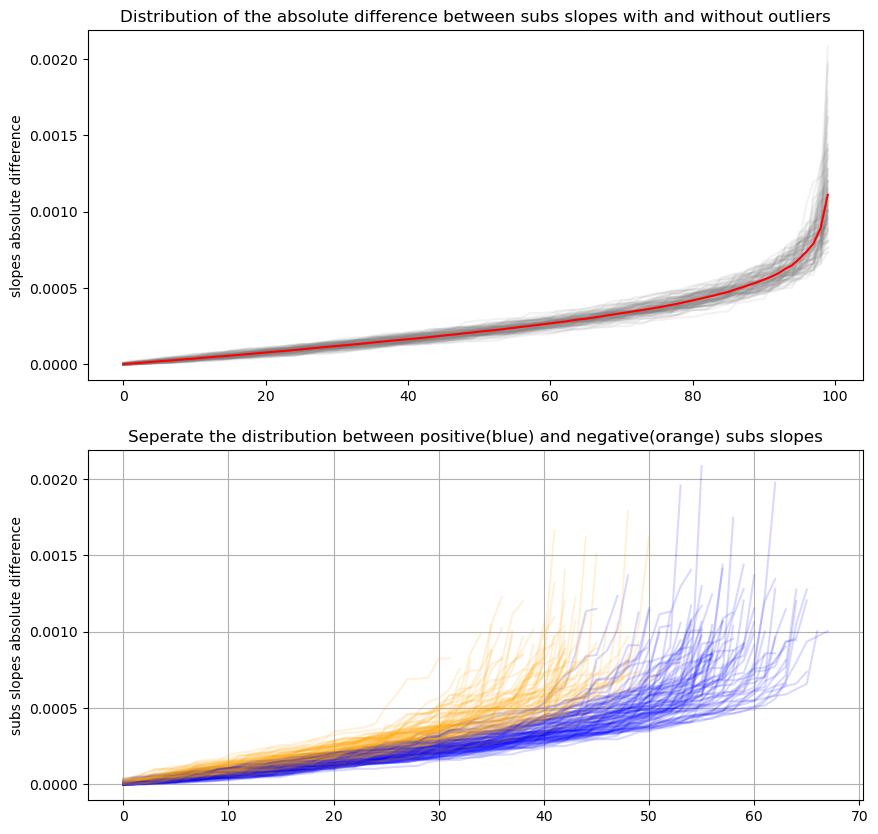

In [179]:
N = 100
mean = 0
mean_pos = np.zeros(N)
mean_neg = np.zeros(N)
fig, ax = plt.subplots(2, figsize=(10, 10))
for i in range(N):
    sample_diff_slopes = sample_from_dict(diff_subs)
    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    mean += sample_diff_slopes_df.slopes.sort_values().values / N
    ax[0].plot(range(len(sample_diff_slopes_df.index)), sample_diff_slopes_df.slopes.sort_values(), color="grey", alpha=0.1)

    #######################################################################################################################

    sample_dict_subs_with_outliers = {key: dict_subs_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
    sample_dict_subs_without_outliers = {key: dict_subs_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_subs_with_outliers, orient='index', columns=['slopes'])
    sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_subs_without_outliers, orient='index', columns=['slopes'])

    s = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes >= 0]
    u = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(s.index)]
    # mean_pos += np.hstack([u.slopes.sort_values().values, np.ones(N - len(u.slopes.sort_values().values)) * u.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(u)), u.slopes.sort_values(), color="blue", alpha=0.15)

    t = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes < 0]
    v = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(t.index)]
    # mean_neg += np.hstack([v.slopes.sort_values().values, np.ones(N - len(v.slopes.sort_values().values)) * v.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(v)), v.slopes.sort_values(), color="orange", alpha=0.15)

ax[0].plot(range(len(sample_diff_slopes_df.index)), mean, color="red")
ax[0].set_title("Distribution of the absolute difference between subs slopes with and without outliers")
ax[0].set_ylabel("slopes absolute difference")

ax[1].set_title("Seperate the distribution between positive(blue) and negative(orange) subs slopes")
ax[1].set_ylabel("subs slopes absolute difference")
ax[1].grid()

We have basically the same graphs which could have been predict since views and subs are corrolated. The more subs the more views you have.

# Clustering

We drop the rows with NaN values to balance the dropping process : we previously dropped channels with NaN values, now we drop timestamps. Also, we can see that rows with NaN values correspond to the first and last timestamp.

In [8]:
views_timeseries = pd.pivot_table(long_timeseries, values='delta_views', index=['datetime'], columns=['channel'])
date_index = views_timeseries.index

In [9]:
def exp_smoothing(series,decay):
    return series.ewm(com=decay).mean()

def rolling_smoothing(series,span):
    return series.rolling(span,min_periods=1).mean()

views_timeseries = exp_smoothing(views_timeseries,2)
views_timeseries.head()

channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,UC--LAVm36WiCmqQbekV17qQ,UC--MxpGXJ3LVD8KvlNzRlcA,UC--SaadDxRXz729rtbQqyBA,...,UCzzfu83LhPMMuhtDVA75rfw,UCzzgEOi0xR9SuflkXmTQv6g,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-12,4121.281000,27776.422000,75579.474000,111415.917000,56396.365000,176101.714000,1703.115000,262139.146000,154464.932000,78428.974000,...,82980.260000,78330.370000,3388.875000,8655.021000,370.125000,17796.646000,7980.000000,37286.031000,0.0,66848.464000
2017-03-19,3647.393800,29052.003400,78872.827200,86669.217600,50291.290000,181965.323200,1564.917600,277481.958400,159191.285600,82815.261400,...,71532.232400,82824.760600,2842.471800,9642.833400,265.275000,18290.795800,10865.634600,46897.437000,0.0,64893.682600
2017-03-26,3582.495368,31357.148579,87345.111632,70427.343632,48915.484158,191871.544474,1470.472263,249851.887632,170062.793158,87780.839263,...,65167.703158,80593.990474,2377.497316,9812.433474,228.213947,17431.912158,9698.119263,45341.723053,0.0,59659.028895
2017-04-02,3439.410169,33683.866692,81295.745169,60058.370123,45415.175015,186636.721969,1316.001000,231588.305200,154903.748185,81769.697062,...,64031.319615,75690.886231,2823.978738,9945.359262,218.628138,16567.005723,9554.669815,42546.299631,0.0,50619.595508
2017-04-09,3129.792403,40480.528057,90615.161716,54358.860739,47620.342427,212113.727991,1252.179526,239148.587919,167845.034427,86745.027218,...,64826.897156,72178.562607,2826.002303,10076.318502,219.906427,18378.973142,10498.090322,50817.301905,0.0,49414.395929


In [10]:
series = np.array([views_timeseries[col].values for col in views_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)
print(train.shape)
print(test.shape)
print(validation.shape)

(65396, 133)
(14014, 133)
(14013, 133)


In [11]:
def partial_minmax(factor):
    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in train])
    for i in range(len(train)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            train[i] = (train[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            train[i] = train[i]-minmax[i][0]

    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in test])
    for i in range(len(test)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            test[i] = (test[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            test[i] = test[i]-minmax[i][0]

    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in validation])
    for i in range(len(validation)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            validation[i] = (validation[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            validation[i] = validation[i]-minmax[i][0]
            
def full_minmax(train,test,validation):
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)
    validation = scaler.fit_transform(validation)
    
def partial_maxabs(factor):
    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in train])
    for i in range(len(train)):
        if max[i] != 0:
            train[i] = train[i]/max[i]

    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in test])
    for i in range(len(test)):
        if max[i] != 0:
            test[i] = test[i]/max[i]

    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in validation])
    for i in range(len(validation)):
        if max[i] != 0:
            validation[i] = validation[i]/max[i]
            
def full_maxabs(train,test,validation):
    scaler = MaxAbsScaler()
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)
    validation = scaler.fit_transform(validation)
    
NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [07:23<00:00, 49.29s/it]


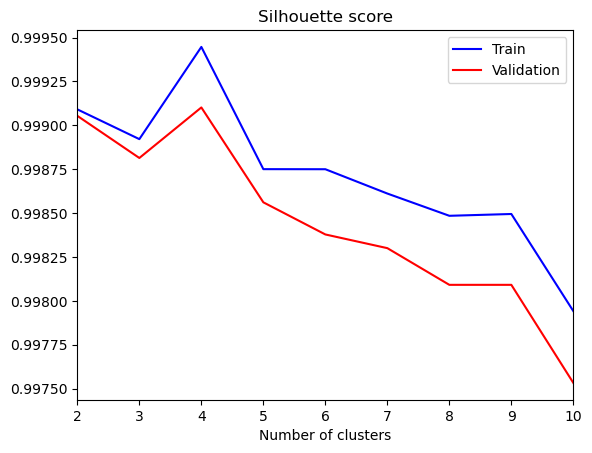

In [12]:
def cross_validation(max_clusters,algorithm):
    range_n_clusters = range(2,max_clusters+1)

    train_silhouette = []
    validation_silhouette = []
    for n_clusters in tqdm(range_n_clusters):
        
        if algorithm == "km":
            km = KMeans(n_clusters=n_clusters, random_state=0).fit(train)

            train_labels = km.predict(train)
            validation_labels = km.predict(validation)
            
        elif algorithm == "birch":
            brc = Birch(n_clusters=n_clusters).fit(train)

            train_labels = brc.predict(train)
            validation_labels = brc.predict(validation)
        
        if all(train_labels==0):
            train_score = 1.0
        else:
            train_score = silhouette_score(train, train_labels)
        train_silhouette.append(train_score)
        
        if all(validation_labels==0):
            validation_score = 1.0
        else:
            validation_score = silhouette_score(validation, validation_labels)
        validation_silhouette.append(validation_score)

    plt.plot(range_n_clusters,train_silhouette,color="blue",label="Train")
    plt.plot(range_n_clusters,validation_silhouette,color="red",label="Validation")
    plt.title("Silhouette score")
    plt.xticks(range_n_clusters)
    plt.xlabel("Number of clusters")
    plt.legend()
    plt.xlim([2,max_clusters])

cross_validation(10,"km")

In [30]:
def km_show_clusters_with_series(train_labelled,test_labelled,clusterer,WIDTH=2):
    
    fig = plt.figure(constrained_layout=True,figsize=(10,10))

    subfigs = fig.subfigures(1, 2)
    
    subfigs[0].suptitle("Train")
    axs = subfigs[0].subplots(math.ceil(N_CLUSTERS/WIDTH),WIDTH,sharex=True)
    cluster_sizes = {}
    for label in clusterer.labels_:
        cluster_sizes[label] = 0
    for label,serie in tqdm(train_labelled):
        i = math.floor(label/WIDTH)
        j = label%WIDTH
        axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.01)
        cluster_sizes[label] = cluster_sizes[label] + 1
    i = 0
    j = 0
    for cluster in clusterer.cluster_centers_:
        axs[(i,j)].plot(date_index,cluster,c="red")
        axs[(i,j)].tick_params(labelrotation=45,labelsize=8)
        axs[(i,j)].set_title("Cluster "+str(i*WIDTH+j+1)+", size "+str(cluster_sizes[i*WIDTH+j]),fontsize=10)
        j += 1
        if j >= WIDTH:
            i += 1
            j = 0
            
    subfigs[1].suptitle("Test")
    axs = subfigs[1].subplots(math.ceil(N_CLUSTERS/WIDTH),WIDTH,sharex=True)
    cluster_sizes = {}
    for label in clusterer.labels_:
        cluster_sizes[label] = 0
    for label,serie in tqdm(test_labelled):
        i = math.floor(label/WIDTH)
        j = label%WIDTH
        axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.1)
        cluster_sizes[label] = cluster_sizes[label] + 1
    i = 0
    j = 0
    for cluster in clusterer.cluster_centers_:
        axs[(i,j)].plot(date_index,cluster,c="red")
        axs[(i,j)].tick_params(labelrotation=45,labelsize=8)
        axs[(i,j)].set_title("Cluster "+str(i*WIDTH+j+1)+", size "+str(cluster_sizes[i*WIDTH+j]),fontsize=10)
        j += 1
        if j >= WIDTH:
            i += 1
            j = 0

100%|███████████████████████████████████| 14014/14014 [00:10<00:00, 1386.97it/s]


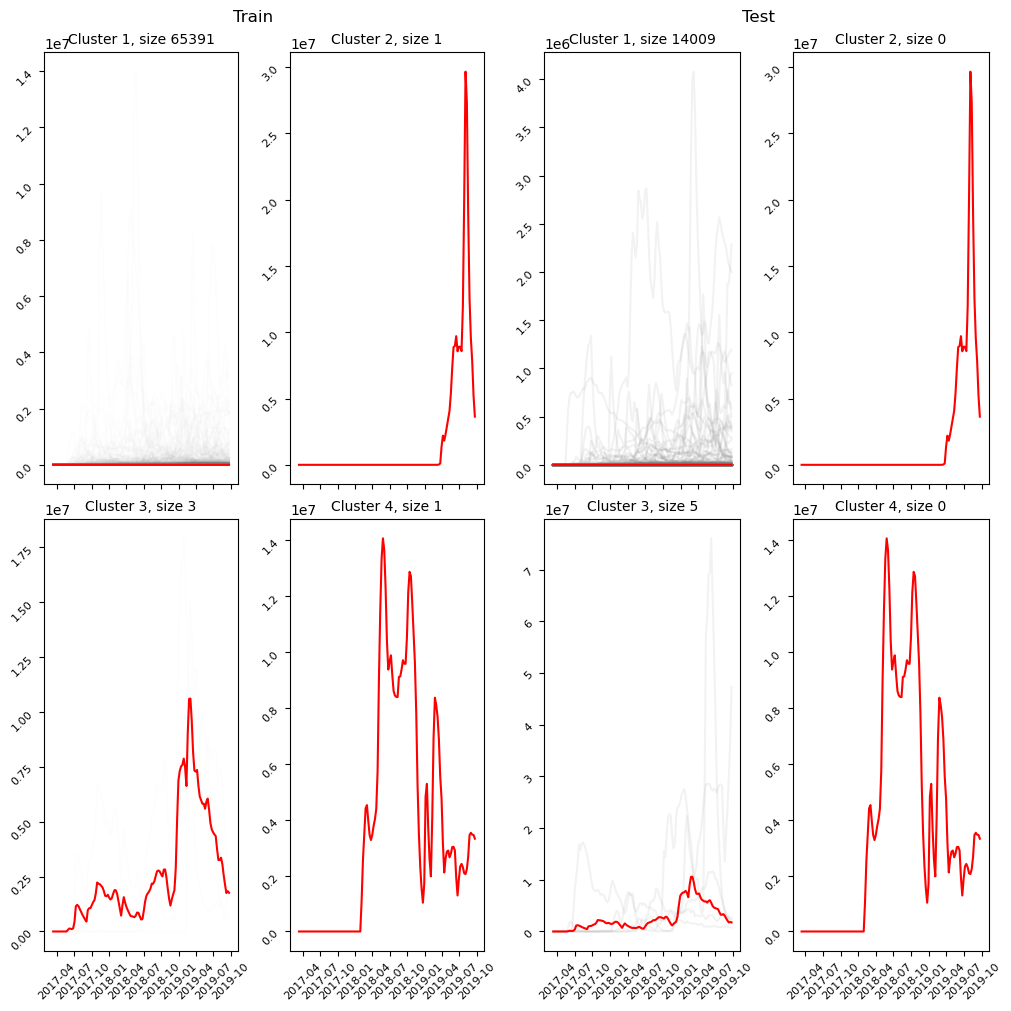

In [14]:
N_CLUSTERS = 4
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km)

In [15]:
subs_timeseries = pd.pivot_table(long_timeseries, values='delta_subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [07:22<00:00, 49.14s/it]


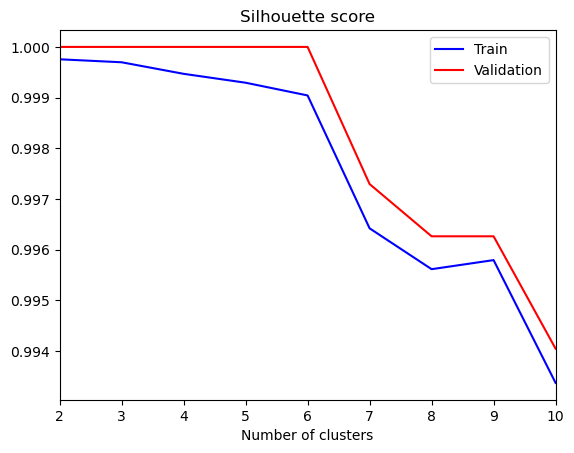

In [16]:
cross_validation(10,"km")

In [ ]:
# Silhouette score of one until we add many clusters, clustering not worth it in this case

In [17]:
videos_timeseries = pd.pivot_table(long_timeseries, values='delta_videos', index=['datetime'], columns=['channel'])
date_index = videos_timeseries.index

videos_timeseries = exp_smoothing(videos_timeseries,2)

series = np.array([videos_timeseries[col].values for col in videos_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [07:40<00:00, 51.17s/it]


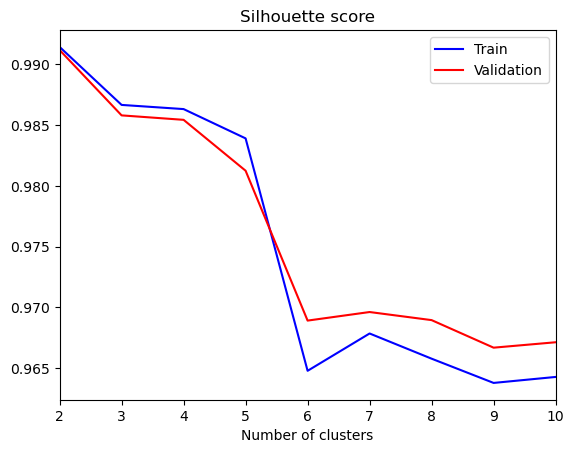

In [18]:
cross_validation(10,"km")

100%|███████████████████████████████████| 14014/14014 [00:09<00:00, 1417.56it/s]


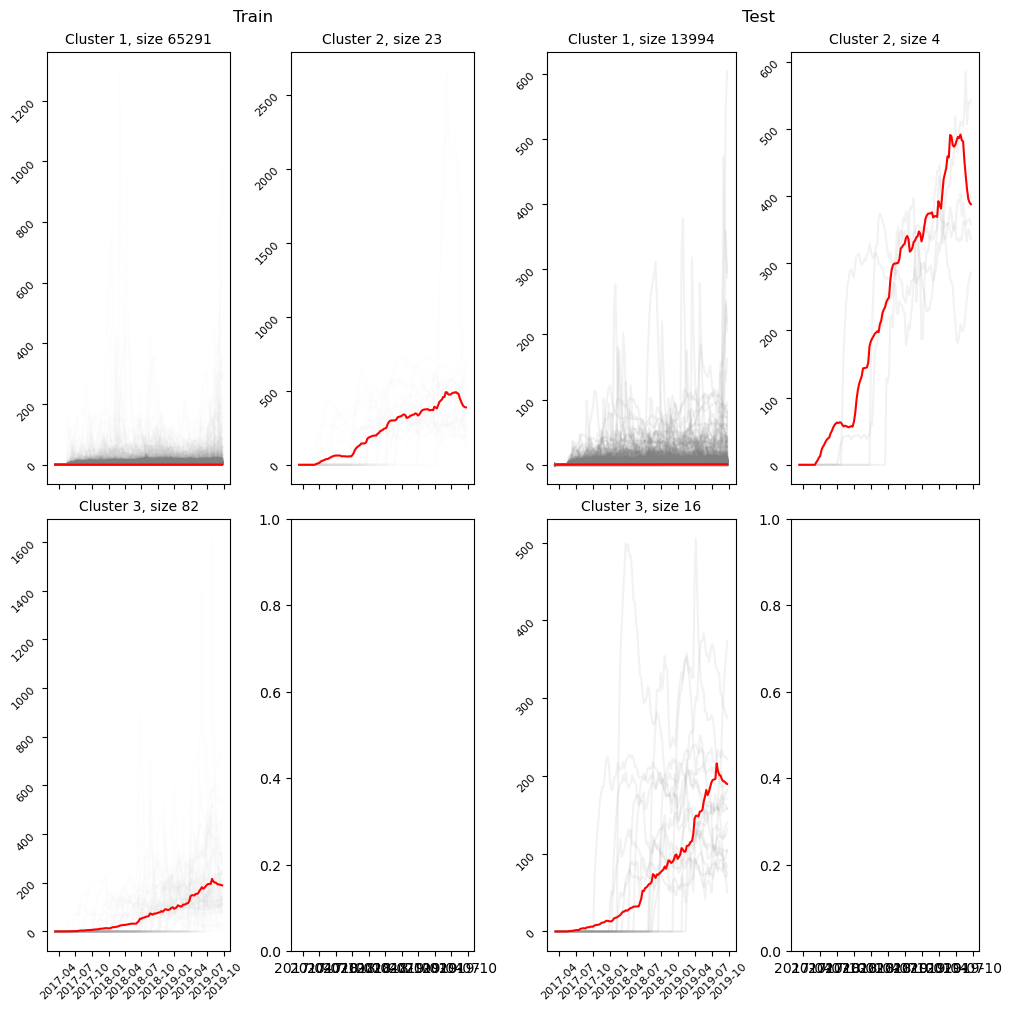

In [32]:
N_CLUSTERS = 3
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km)

In [19]:
# We did the same with Birch but didn't get better results

In [ ]:
# Now only on Gaming category

In [20]:
gaming_timeseries = long_timeseries[long_timeseries['category']=="Gaming"]
gaming_timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
1563,UCOUXsjwRdNQK2YqBNp7zrGQ,Gaming,2017-03-12,519042.245,18032.542,12699.292,121.214,87,6,8
1564,UCOUXsjwRdNQK2YqBNp7zrGQ,Gaming,2017-03-19,535277.286,16235.042,12841.224,141.932,90,3,9
1565,UCOUXsjwRdNQK2YqBNp7zrGQ,Gaming,2017-03-26,548312.675,13035.389,12974.147,132.923,92,2,6
1566,UCOUXsjwRdNQK2YqBNp7zrGQ,Gaming,2017-04-02,558144.125,9831.450,13076.500,102.353,94,2,5
1567,UCOUXsjwRdNQK2YqBNp7zrGQ,Gaming,2017-04-09,566407.500,8263.375,13158.000,81.500,96,2,5


In [ ]:
views_timeseries = pd.pivot_table(gaming_timeseries, values='delta_views', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

In [ ]:
cross_validation(10,"km")

In [ ]:
N_CLUSTERS = 9 ###
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km)

In [ ]:
subs_timeseries = pd.pivot_table(gaming_timeseries, values='delta_subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

In [ ]:
cross_validation(10,"km")

In [ ]:
N_CLUSTERS = 9 ###
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km)

In [ ]:
videos_timeseries = pd.pivot_table(gaming_timeseries, values='delta_videos', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

In [ ]:
cross_validation(10,"km")

In [ ]:
N_CLUSTERS = 9 ###
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km)

# Forecasting

In [3]:
views_timeseries = pd.pivot_table(long_timeseries, values='views', index=['datetime'], columns=['channel'])
date_index = views_timeseries.index

In [4]:
views_timeseries = views_timeseries.sample(5000,axis=1)

In [5]:
def exp_smoothing(series,decay):
    return series.ewm(com=decay).mean()

def rolling_smoothing(series,span):
    return series.rolling(span,min_periods=1).mean()

views_timeseries = exp_smoothing(views_timeseries,2)
views_timeseries.head()

channel,UCNIPltykIATy0PhRp82uNMQ,UCKDSzvjPZRIwSwWZstoy79w,UCwfWwrUCbuV86URV6uF8dMw,UCn3-IBtTKq8ZTV5hiZT-7bQ,UCiiyNz0Q_mJbl2se3JMY-IA,UCm3i_fqq8dqsV-dTAriv2KA,UClgUBeM4VhdgcHFG-aVlg1g,UCQ0_eOi8HgUOZ44-UAepwsg,UC0qo_rEBD9MI4P68t95kLNA,UCWdoh5Um2dOEvM2ouU_lQUw,...,UCupPm5ZZJwI-FqZFToHBLwA,UCNFbcu5tU8eFPhjORNPq9pQ,UCBn0VobeNWV_SZ6UV65UIJw,UCSfHdIQRje_PNaJeSRLXUhQ,UCJGIcagDUiiVmguJj_noIGw,UC7UkQQq99_cXAspy5HP7r3g,UCgLUKVbTKqX9nQgf0QBhUMA,UCmQOf_2PVMdX7YrXgYqtp-Q,UCl9AgUauofjFUHMlOKd_K6Q,UC10lecpry6dGjTPb2AZpsxg
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-12,3.597713e+06,1.113826e+08,2.583100e+07,4.602243e+06,8.611249e+06,757013.448000,1.768573e+06,15772.750000,1.232294e+06,2.323525e+08,...,1.885480e+07,5.744192e+07,5.062479e+08,1.276911e+07,7.194481e+05,4.005332e+07,1.236830e+06,1648.099000,2.657491e+06,9382.281000
2017-03-19,3.642043e+06,1.130996e+08,2.617950e+07,4.916832e+06,8.620062e+06,759823.963800,1.802476e+06,16509.159400,1.236247e+06,2.329420e+08,...,1.893181e+07,5.750354e+07,5.083587e+08,1.279700e+07,7.824475e+05,4.008132e+07,1.242195e+06,1794.571000,2.661585e+06,9522.734400
2017-03-26,3.695943e+06,1.145467e+08,2.650626e+07,5.280129e+06,8.630039e+06,763340.616789,1.848230e+06,17361.977895,1.240464e+06,2.336010e+08,...,1.901743e+07,5.756858e+07,5.105948e+08,1.282381e+07,8.512467e+05,4.011099e+07,1.248629e+06,1958.646684,2.665962e+06,9653.426053
2017-04-02,3.761396e+06,1.161500e+08,2.683259e+07,5.709450e+06,8.639733e+06,767264.776108,1.894393e+06,18282.751046,1.245272e+06,2.343963e+08,...,1.907934e+07,5.763311e+07,5.131283e+08,1.284911e+07,9.390844e+05,4.014265e+07,1.255448e+06,2113.783831,2.670865e+06,9807.564462
2017-04-09,3.835737e+06,1.178731e+08,2.721978e+07,6.203797e+06,8.649584e+06,771216.827104,1.936517e+06,19309.816441,1.250096e+06,2.352115e+08,...,1.915762e+07,5.769614e+07,5.156503e+08,1.287264e+07,1.057612e+06,4.017770e+07,1.262382e+06,2297.364445,2.675811e+06,9994.828223


In [6]:
views_timeseries = views_timeseries.reset_index()
views_timeseries['datetime'] = pd.to_datetime(views_timeseries['datetime'])
views_timeseries['year'] = views_timeseries['datetime'].dt.year
views_timeseries['month'] = views_timeseries['datetime'].dt.month
views_timeseries['day'] = views_timeseries['datetime'].dt.day
views_timeseries = views_timeseries.drop('datetime',axis=1)
views_timeseries.head()

channel,UCNIPltykIATy0PhRp82uNMQ,UCKDSzvjPZRIwSwWZstoy79w,UCwfWwrUCbuV86URV6uF8dMw,UCn3-IBtTKq8ZTV5hiZT-7bQ,UCiiyNz0Q_mJbl2se3JMY-IA,UCm3i_fqq8dqsV-dTAriv2KA,UClgUBeM4VhdgcHFG-aVlg1g,UCQ0_eOi8HgUOZ44-UAepwsg,UC0qo_rEBD9MI4P68t95kLNA,UCWdoh5Um2dOEvM2ouU_lQUw,...,UCSfHdIQRje_PNaJeSRLXUhQ,UCJGIcagDUiiVmguJj_noIGw,UC7UkQQq99_cXAspy5HP7r3g,UCgLUKVbTKqX9nQgf0QBhUMA,UCmQOf_2PVMdX7YrXgYqtp-Q,UCl9AgUauofjFUHMlOKd_K6Q,UC10lecpry6dGjTPb2AZpsxg,year,month,day
0,3.597713e+06,1.113826e+08,2.583100e+07,4.602243e+06,8.611249e+06,757013.448000,1.768573e+06,15772.750000,1.232294e+06,2.323525e+08,...,1.276911e+07,7.194481e+05,4.005332e+07,1.236830e+06,1648.099000,2.657491e+06,9382.281000,2017,3,12
1,3.642043e+06,1.130996e+08,2.617950e+07,4.916832e+06,8.620062e+06,759823.963800,1.802476e+06,16509.159400,1.236247e+06,2.329420e+08,...,1.279700e+07,7.824475e+05,4.008132e+07,1.242195e+06,1794.571000,2.661585e+06,9522.734400,2017,3,19
2,3.695943e+06,1.145467e+08,2.650626e+07,5.280129e+06,8.630039e+06,763340.616789,1.848230e+06,17361.977895,1.240464e+06,2.336010e+08,...,1.282381e+07,8.512467e+05,4.011099e+07,1.248629e+06,1958.646684,2.665962e+06,9653.426053,2017,3,26
3,3.761396e+06,1.161500e+08,2.683259e+07,5.709450e+06,8.639733e+06,767264.776108,1.894393e+06,18282.751046,1.245272e+06,2.343963e+08,...,1.284911e+07,9.390844e+05,4.014265e+07,1.255448e+06,2113.783831,2.670865e+06,9807.564462,2017,4,2
4,3.835737e+06,1.178731e+08,2.721978e+07,6.203797e+06,8.649584e+06,771216.827104,1.936517e+06,19309.816441,1.250096e+06,2.352115e+08,...,1.287264e+07,1.057612e+06,4.017770e+07,1.262382e+06,2297.364445,2.675811e+06,9994.828223,2017,4,9


In [7]:
steps_to_predict = 33
data_train = views_timeseries[:-steps_to_predict]
data_test  = views_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

In [8]:
X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [ ]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

In [10]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UCFkjRL-k_H6H0Tbc-wrTUfg,UCyc9mFN1Gf24xfO0cl8gJug,UCTWm02t-F0pOPhmOnI7u4gg,UCr030Gq7lJ30za5ReYuUaLg,UCv8MC9vtOplOTELMzgE7t5w,UCMY9-XhJosAEtKghDTpMXbQ,UCGM9HPMJD9pNHcgYrFYLkQg,UCZGzlFotnCeAqyL-hubooMg,UCKrrATalRpJ-H5ltP788DkA,UCaLCRvvau4acqQ4eLGZUywA,...,UCRcam0RTtiv85oGAiPpbz6g,UC4-47F1ofGOcSDUJhO71MYg,UCaF-3nIudS1jw7_yDo_En8A,UCGR1oe259xuhCSaq12h_aQQ,UCWTAzBlHWOf17F8zN8HNJXg,UCBt9xxFQAE8pI6X61chU-hQ,UC2wwdeitpLuk6mmG_ouXhSA,UCMQ7tgo5P_fcgcflG3kaK_A,UCS0Jru4Ws1I-ofw8QvSAghg,UCOZlALOP7ZqodgQgH4BybqA
0,22379480.0,4205635.0,337254880.0,19171098.0,100023864.0,16982314.0,59724904.0,8783914.0,18523906.0,19664028.0,...,7155295.0,39597852.0,1630178.625,24420980.0,3579997.75,15946399.0,21800690.0,7192655.0,508506.0625,35007832.0
1,22380900.0,4203657.0,337242624.0,19165102.0,100027848.0,16985916.0,59695844.0,8783013.0,18522286.0,19661004.0,...,7159214.0,39758500.0,1629944.375,24360772.0,3578057.75,15943070.0,21800080.0,7201071.0,509769.5625,35009844.0
2,22365276.0,4204970.0,336120544.0,19185514.0,99817992.0,16977618.0,59694160.0,8776204.0,18522532.0,19657754.0,...,7160548.5,39646324.0,1627980.125,24453926.0,3570895.25,15941908.0,21789548.0,7167150.0,510577.8750,35001348.0
3,22379710.0,4205168.0,337371040.0,19207646.0,100043512.0,16985792.0,59742284.0,8784640.0,18519028.0,19671102.0,...,7163068.0,39464684.0,1631353.375,24535996.0,3584046.25,15934646.0,21799578.0,7198498.0,512537.1875,35032292.0
4,22379834.0,4205056.5,337705952.0,19174326.0,100026048.0,16986480.0,59598404.0,8783428.0,18522908.0,19664940.0,...,7154913.5,39161660.0,1629834.500,24401748.0,3579468.75,15935423.0,21800808.0,7205258.5,507654.1875,35011376.0


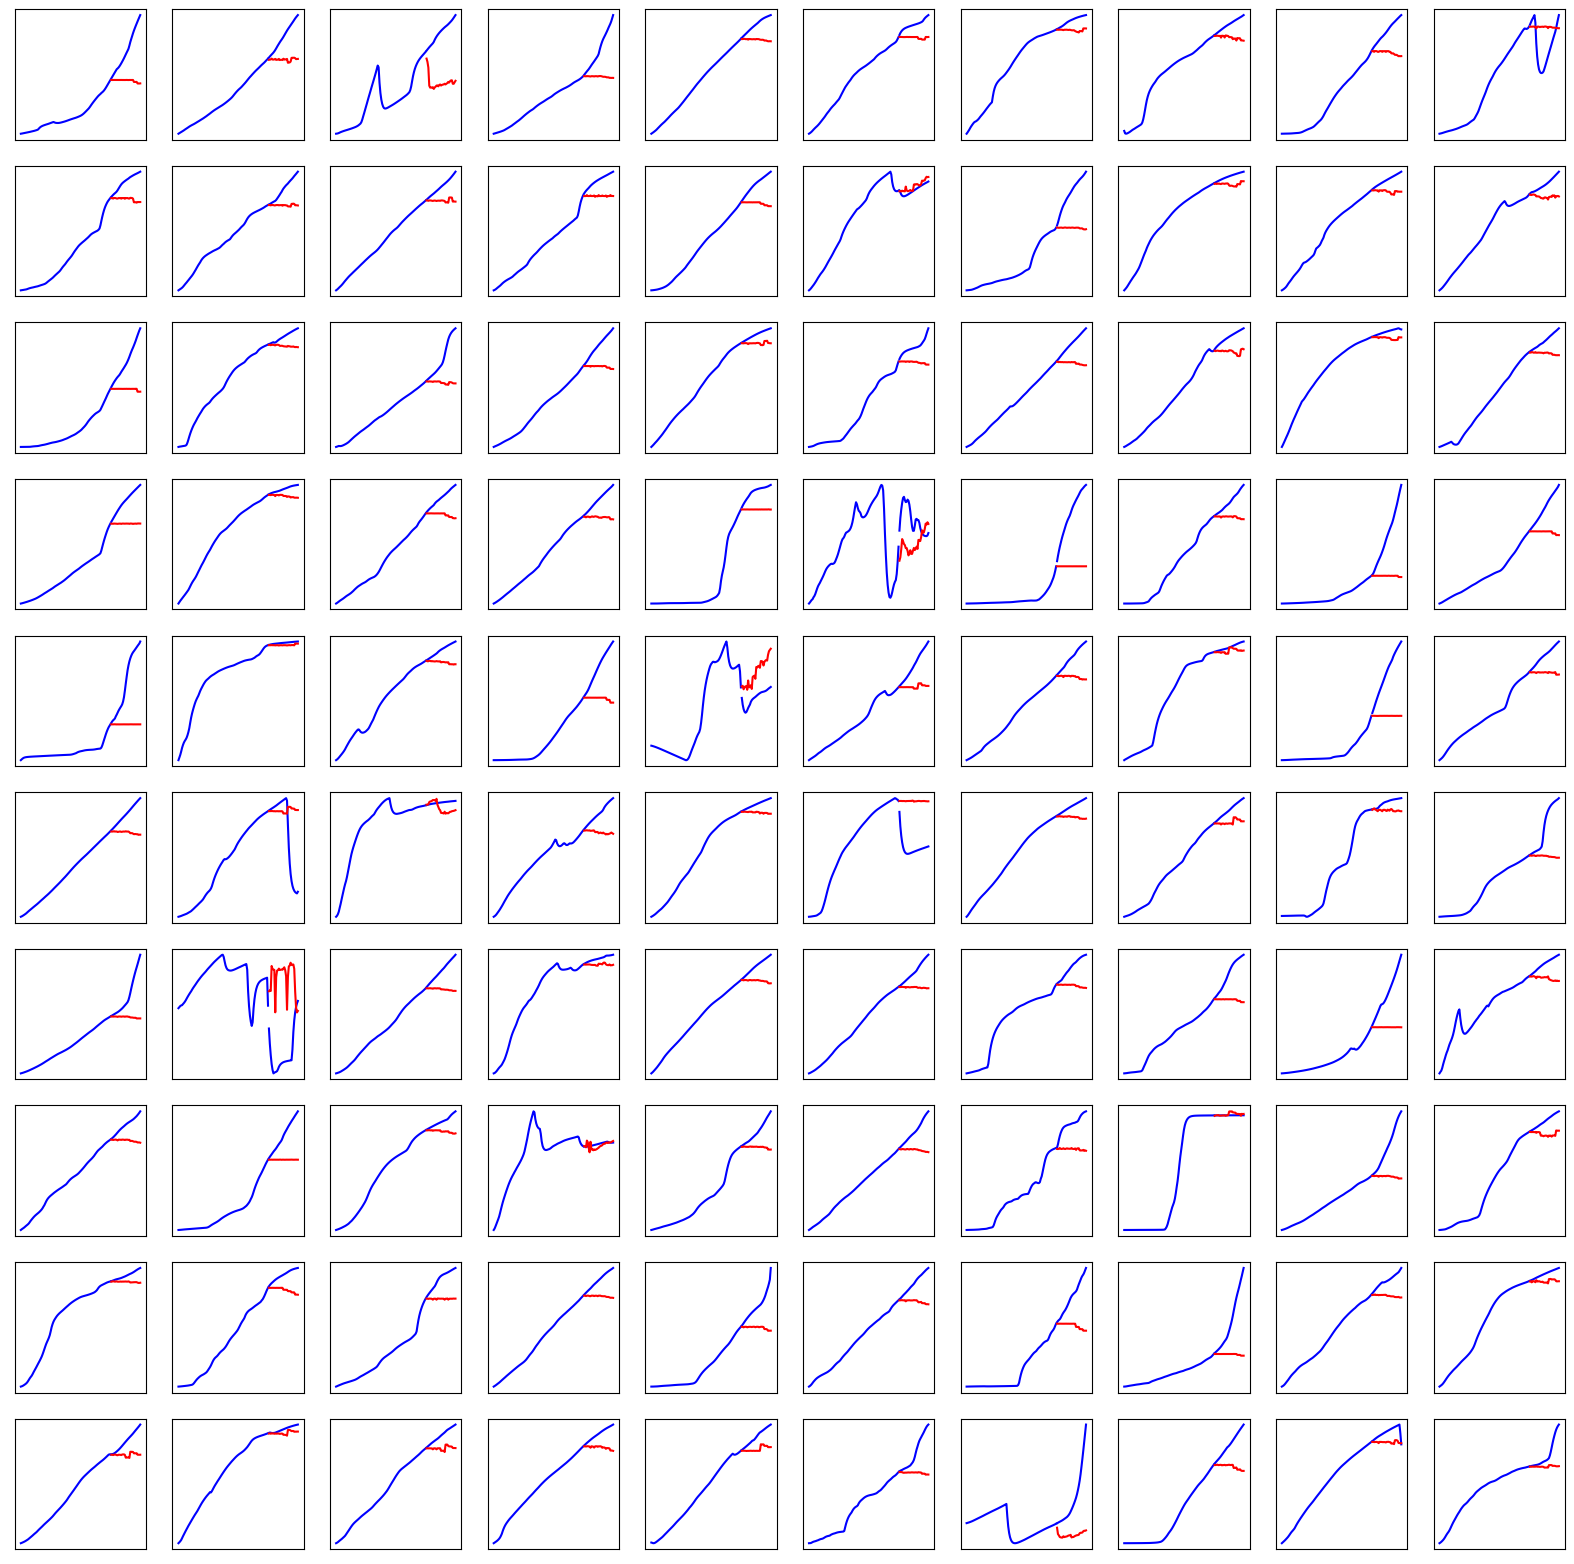

In [19]:
fig,axs = plt.subplots(10,10,figsize=(20,20))

selected = Y_train.sample(100,axis=1).columns

for i in range(10):
    for j in range(10):
        axs[(i,j)].set_xticks([])
        axs[(i,j)].set_yticks([])
        axs[(i,j)].plot(dates_train,Y_train[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_test[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_predict[selected[i*10+j]],color='red')

In [5]:
subs_timeseries = pd.pivot_table(long_timeseries, values='subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = subs_timeseries.sample(5000,axis=1)

subs_timeseries = exp_smoothing(subs_timeseries,2)

subs_timeseries = subs_timeseries.reset_index()
subs_timeseries['datetime'] = pd.to_datetime(subs_timeseries['datetime'])
subs_timeseries['year'] = subs_timeseries['datetime'].dt.year
subs_timeseries['month'] = subs_timeseries['datetime'].dt.month
subs_timeseries['day'] = subs_timeseries['datetime'].dt.day
subs_timeseries = subs_timeseries.drop('datetime',axis=1)

steps_to_predict = 33
data_train = subs_timeseries[:-steps_to_predict]
data_test  = subs_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [6]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [7]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UCRD4MGKycXWj8oFU3PYKMWA,UCjGgUtVfpLQpw_qWckhteVw,UC8j8j0DR0d8WKM7QCfN22WQ,UC976cmBIr3xFimgrzPjc8pg,UCGLhPtcmMLt1lW9KUGTS-eQ,UCvzSj2apEbENYRHunmxGu9g,UC37nfT45ze1IvSP9UEdyeCg,UC4_FwMP_wlOYb8yvZkdKJeA,UCDpL0v-Ifie7u05lbfO3zJQ,UC3aAAVFrWZIMIPT4P055cQg,...,UCIJ08w2yQhbF90Bp3PEQcIg,UCDxOHP-pnyWSJAbkmRejg9A,UCZ1YV0C1gGQoVzVHxw5G6aA,UCHQBu0aDgMlUNe8zKHbDyrw,UCVTsocOv4RI8objZOgcsENQ,UCBtsqrRhNlIe5HWcrDzmVeQ,UCKKxxEf5MSZxLwOdl-S6TmQ,UCwBTnF_29p9g2qas9Knyd6Q,UCn3jo0dwmz6GPmlivOBx1nA,UCGGZ_POGmIWG1pQXTDzQv-g
0,183221.765625,70702.265625,640085.4375,334387.90625,12484.554688,45309.234375,11678.196289,1097760.250,220583.609375,13844.616211,...,37168.144531,30331.921875,20411.113281,331629.40625,12939.410156,16179.890625,38938.113281,34164.449219,15670.499023,1090292.125
1,183315.953125,70620.109375,638692.8125,334337.28125,12481.274414,45316.101562,11703.624023,1097975.125,220530.750000,13838.528320,...,37239.289062,30325.066406,20409.615234,331558.43750,12933.819336,16194.486328,38935.402344,34170.039062,15704.264648,1090129.125
2,183444.109375,70709.468750,638407.5000,334337.46875,12438.824219,45278.027344,11655.877930,1099240.125,220461.421875,13869.317383,...,37157.320312,30317.351562,20384.486328,331975.28125,12907.984375,16199.808594,38823.757812,34063.429688,15663.281250,1089966.500
3,183378.281250,71057.812500,640569.8750,334383.28125,12484.798828,45302.097656,11761.278320,1100457.375,220682.390625,13968.821289,...,37203.675781,30328.578125,20427.156250,332339.15625,12936.630859,16197.038086,38936.000000,34198.968750,15700.719727,1092446.000
4,183157.500000,70705.523438,640111.5625,334431.03125,12485.078125,45293.789062,11697.792969,1097627.875,220586.250000,13852.576172,...,37197.132812,30347.152344,20423.880859,331543.46875,12937.190430,16214.102539,38936.195312,34189.023438,15697.485352,1091571.500


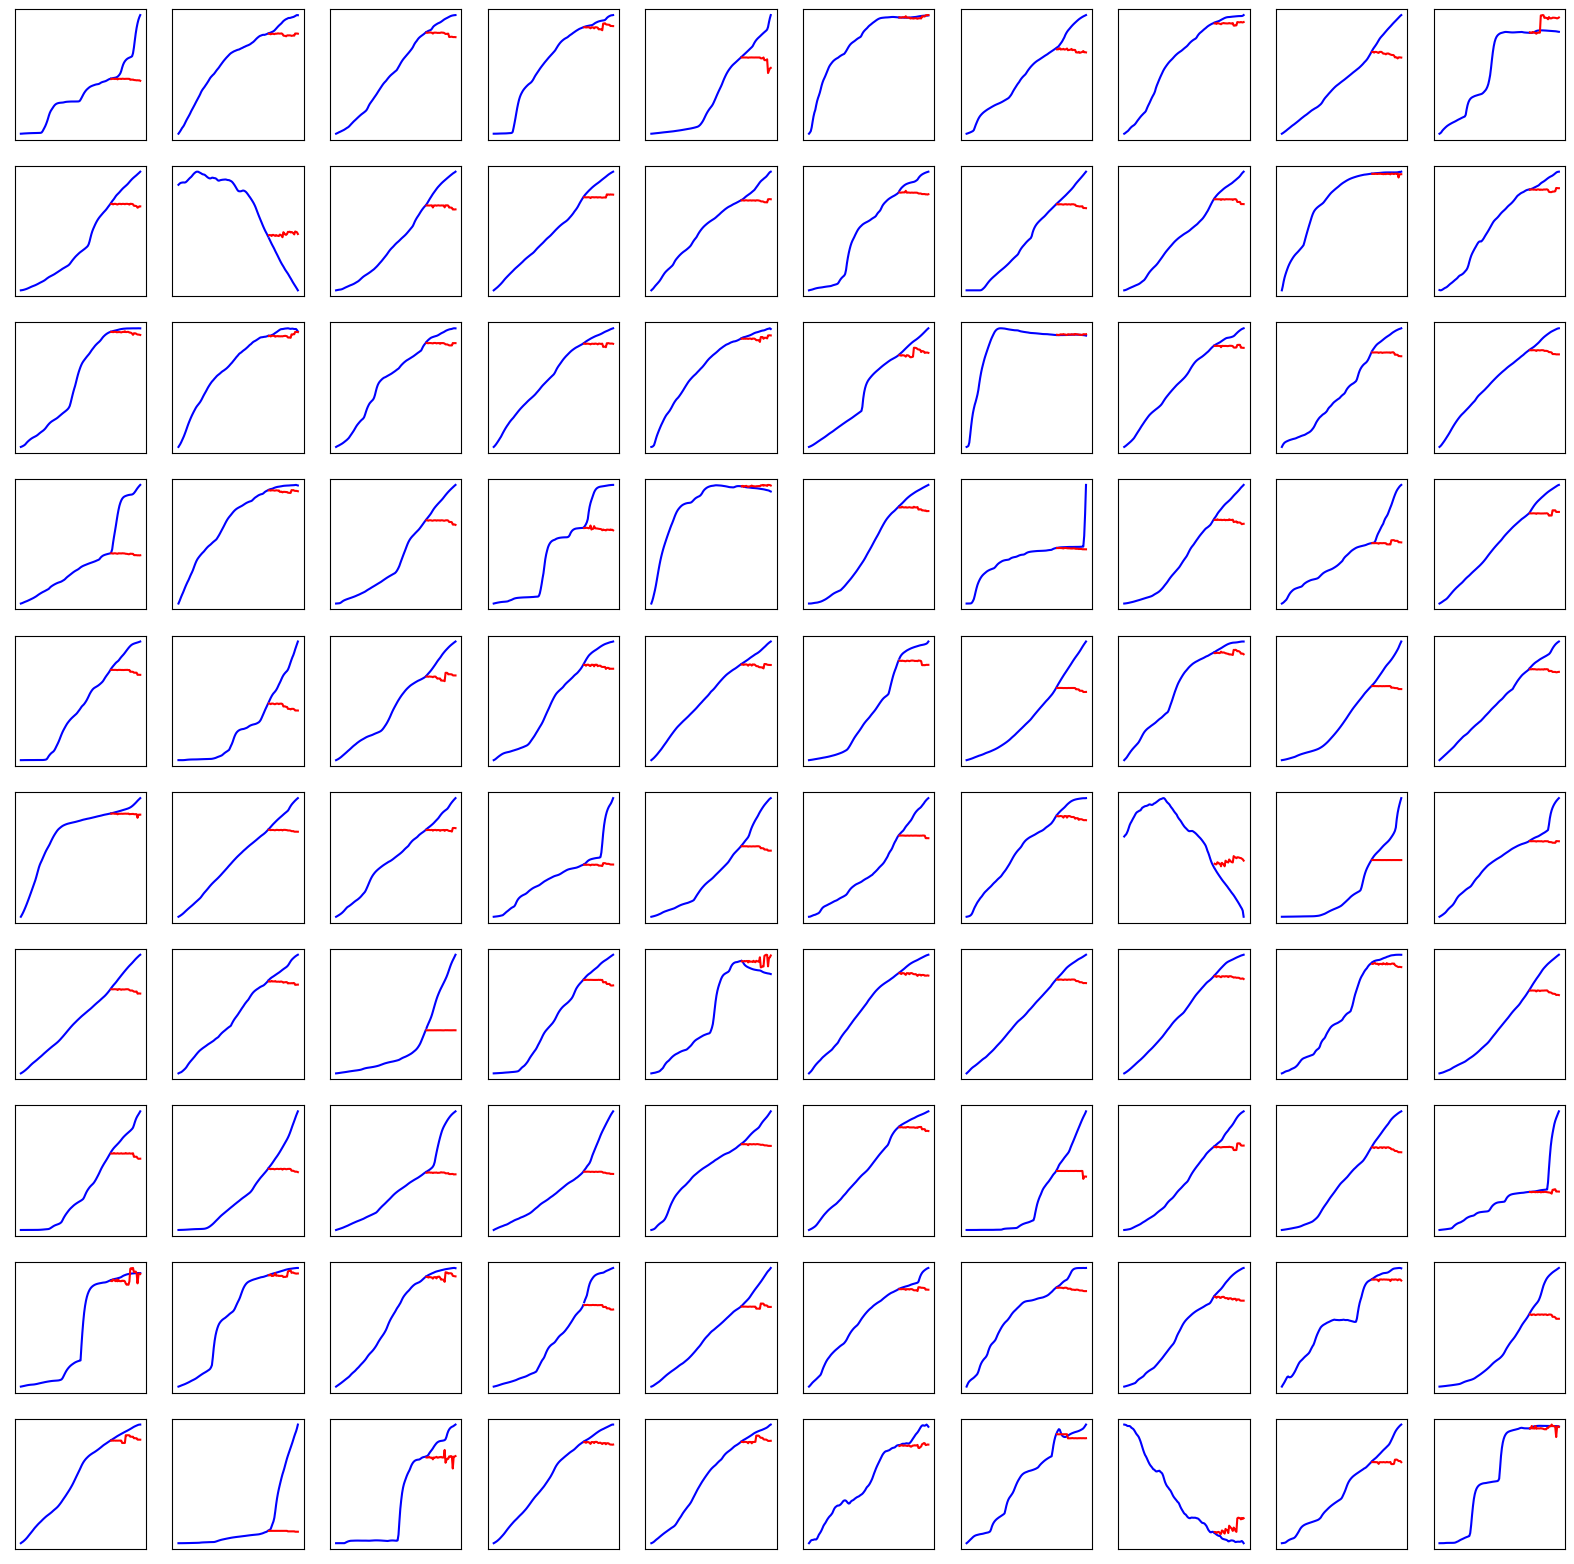

In [8]:
fig,axs = plt.subplots(10,10,figsize=(20,20))

selected = Y_train.sample(100,axis=1).columns

for i in range(10):
    for j in range(10):
        axs[(i,j)].set_xticks([])
        axs[(i,j)].set_yticks([])
        axs[(i,j)].plot(dates_train,Y_train[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_test[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_predict[selected[i*10+j]],color='red')

In [4]:
videos_timeseries = pd.pivot_table(long_timeseries, values='videos', index=['datetime'], columns=['channel'])
date_index = videos_timeseries.index

videos_timeseries = videos_timeseries.sample(5000,axis=1)

videos_timeseries = exp_smoothing(videos_timeseries,2)

videos_timeseries = videos_timeseries.reset_index()
videos_timeseries['datetime'] = pd.to_datetime(videos_timeseries['datetime'])
videos_timeseries['year'] = videos_timeseries['datetime'].dt.year
videos_timeseries['month'] = videos_timeseries['datetime'].dt.month
videos_timeseries['day'] = videos_timeseries['datetime'].dt.day
videos_timeseries = videos_timeseries.drop('datetime',axis=1)

steps_to_predict = 33
data_train = videos_timeseries[:-steps_to_predict]
data_test  = videos_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [5]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [6]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UC1dDig68uYf_1QM7GJ9ecTA,UCQmr80eZZwiZJTLSi69H3gw,UCqVvuWLZ-B5Qa8RwWxnjF5g,UCjqmSaZWzVWgCw6LFV6-0ZA,UCH7OQU5hL0IQcxnFxqropsg,UCJLkqgDlpHqPh-6EeJQ0PiA,UCVG-pKlgkC-dKLm84ALflSw,UCol3skDXWShJbJvEokKM88A,UC1fnAy1rwtrIMmsyO3_Y9xw,UCvuwyvj6BDXUMxZhaXSbabA,...,UC1f7XRZT66-JtNTvszW0O-Q,UCGZmkgX5xXZZboN0-ZRp3_A,UCU-UhEGfi2dj4ePMFluCdUg,UCrCV5tUDXg9d8vvbcoixJbQ,UCSilRxlBwkywBVuWOFUY6FQ,UCGl9jr-1w_jHF4iaDZjBFxQ,UC87ZzP3z2vlmj70FJFVfocA,UCdNc9QtKtiFC_AmKHgiiDpA,UCJzQFJ7tZmYEHQcczU0TXYA,UC3H9ieyNjPZf_XgduxnSCow
0,49.019131,279.015320,46.997654,1685.122681,20.994884,646.018921,303.563416,155.462006,39.795265,115.714516,...,266.370575,232.635468,106.198700,1494.041504,91.927277,42.530937,79.015053,344.616577,56.972214,113.365211
1,49.015896,279.016296,46.976151,1685.859253,21.011597,646.065186,302.899841,155.429840,39.787712,115.277451,...,266.252167,232.637314,106.382034,1494.621948,91.962387,42.547874,79.011223,344.449615,56.971138,113.425888
2,49.093601,278.939209,46.992767,1685.081055,20.968596,646.030212,302.582947,155.459610,39.787712,115.608093,...,266.288818,232.605286,106.343811,1491.253784,92.011909,42.550442,79.008461,344.756439,56.971138,113.332771
3,49.365288,279.030945,46.985348,1685.607056,20.953239,646.334717,302.316406,155.495270,39.795620,114.750679,...,266.530762,232.649536,106.726181,1493.897705,91.972321,42.604832,78.917923,344.889923,56.972214,113.398453
4,49.042007,279.011993,47.000454,1685.319458,20.976231,646.171204,303.847900,155.462006,39.795265,115.317184,...,266.538513,232.638962,106.213631,1489.149414,91.927277,42.589996,78.937523,344.769806,56.972214,113.365211


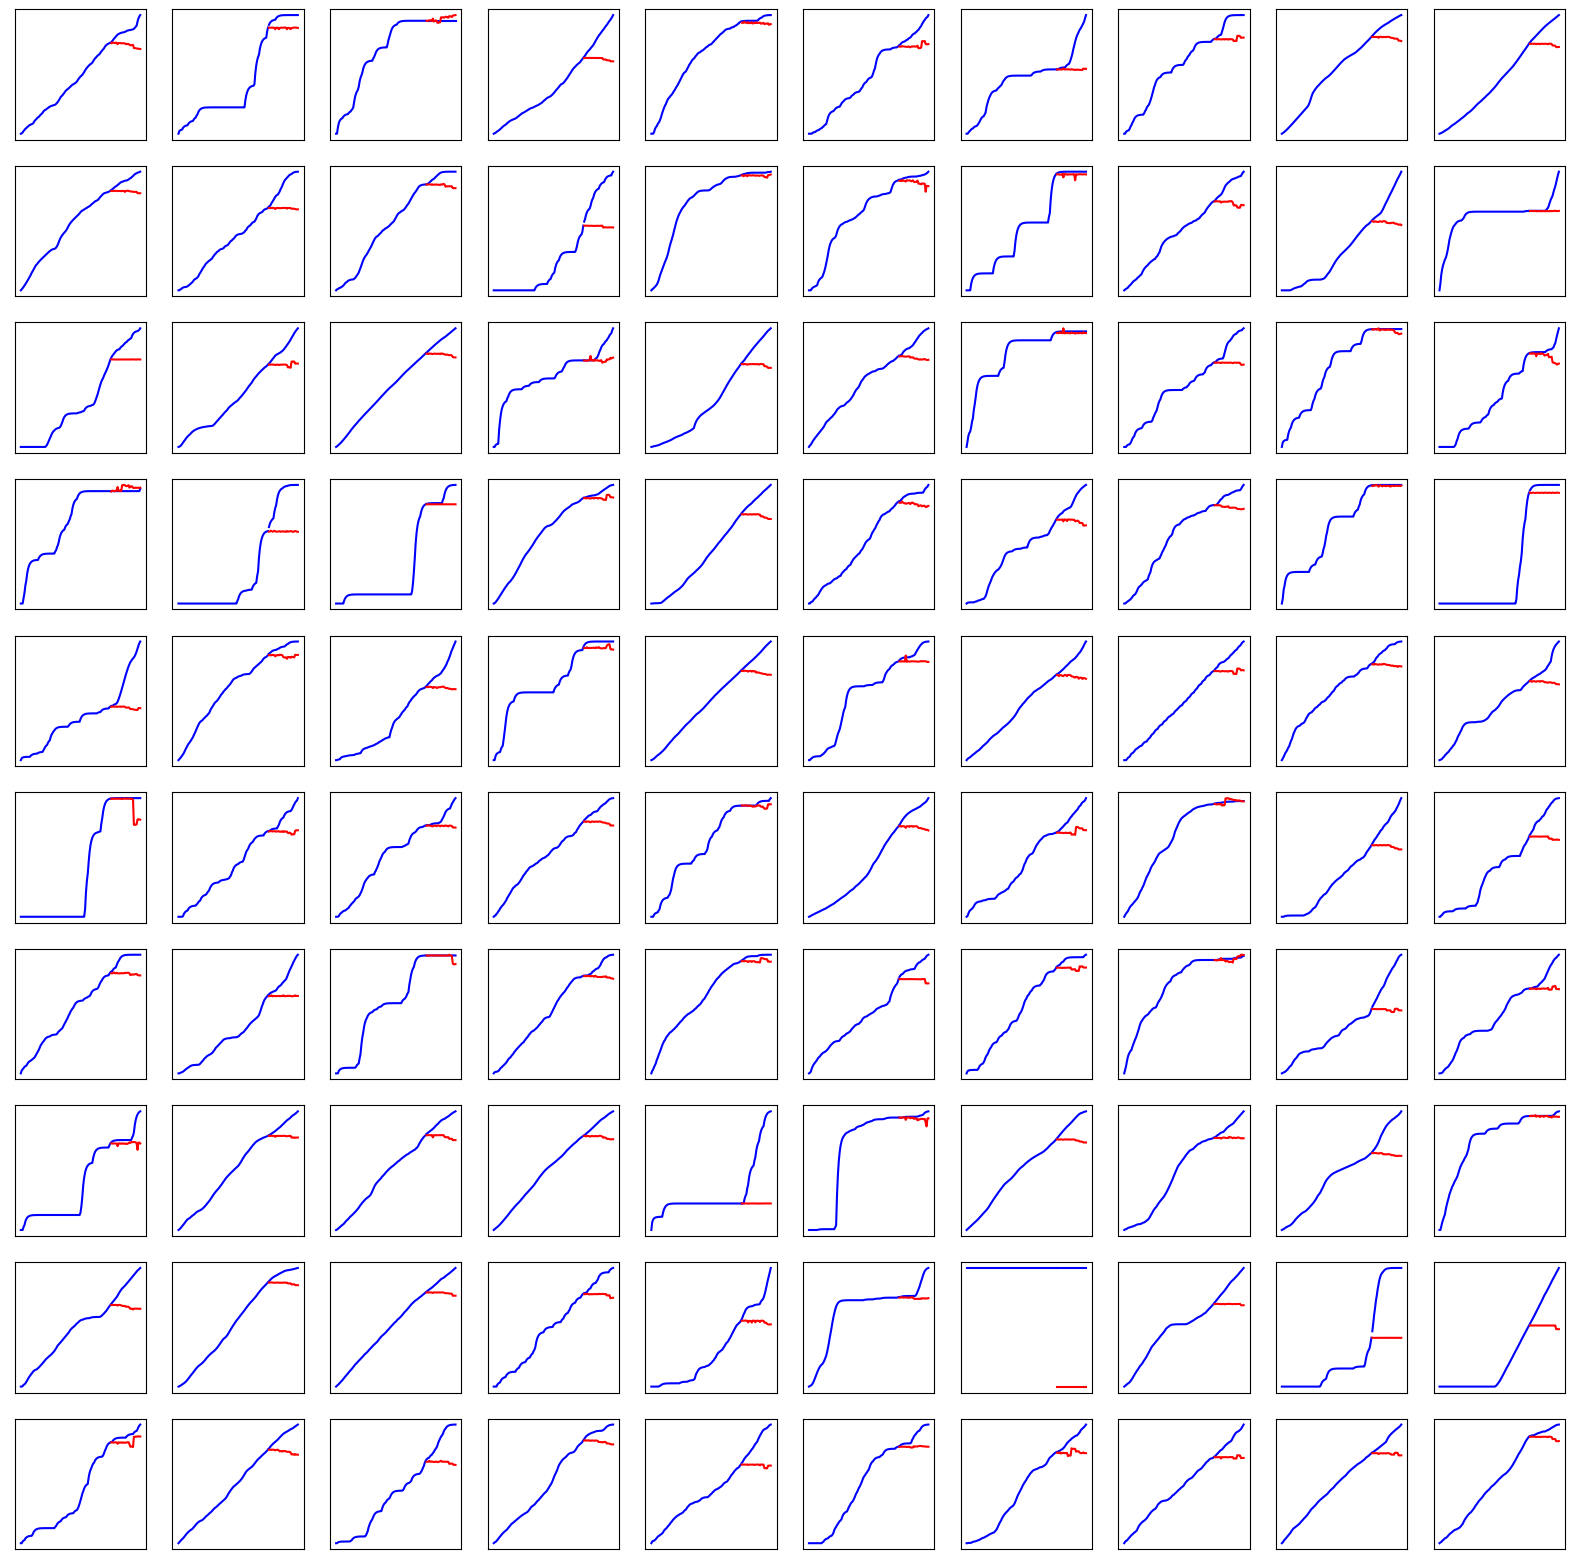

In [7]:
fig,axs = plt.subplots(10,10,figsize=(20,20))

selected = Y_train.sample(100,axis=1).columns

for i in range(10):
    for j in range(10):
        axs[(i,j)].set_xticks([])
        axs[(i,j)].set_yticks([])
        axs[(i,j)].plot(dates_train,Y_train[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_test[selected[i*10+j]],color='blue')
        axs[(i,j)].plot(dates_test,Y_predict[selected[i*10+j]],color='red')